In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [213]:
class RNN:
    # Weights
    W = []
    # Layers
    M = []
    # Bias
    b = []
    # Activation function for each layer
    A = []
    Yhat = []
    costs = []
    lossType = 'mse'
    optimizer = 'none'
    
    def __init__(self):
        self.reset()
    
    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __tanh(self, Z):
        return np.tanh(Z)
    
    def __relu(self,Z):
        return Z * (Z > 0)
    
    # Calls specified activation function
    def __actf(self,Z,ty):
        if ty == 'sigmoid':
            return self.__sigmoid(Z)
        elif ty == 'tanh':
            return self.__tanh(Z)
        elif ty == 'softmax':
            return self.__softmax(Z)
        elif ty == 'none':
            return Z
        else:# ty == 'relu':
            return self.__relu(Z)
        
        # Calls specified activation function derivative
    def __actf_dv(self,Z,ty):
        if ty == 'sigmoid':
            return Z*(1-Z)
        elif ty == 'tanh':
            return (1-Z*Z)
        elif ty == 'none':
            return Z
        else:# ty == 'relu':
            return np.where(Z > 0, 1, 0)
        
    def __softmax(self,A):
        expA = np.exp(A)
        return expA / expA.sum(axis=1,keepdims=True)
    
    # Cross-entropy cost for softmax
    def __cost(self,T,Y,ty):
        if ty == 'ce':
            return self.__cross_entropy(T,Y)
        elif ty == 'mse':
            return self.__mean_squared(T,Y)
    
    def __cross_entropy(self,T,Y):
        tot = (-T * np.log(Y))
        return tot.sum()
    
    def __mean_squared(self,T,Y):
        tot = np.square(T - Y)
        return tot.sum()
    
    def classification_rate(self,T):
        Yhat = NeuralNetwork.Yhat
        Yp = np.argmax(Yhat,axis=1)
        print('Classification rate: ', np.mean(T == Yp))
    
    # Adds hidden layer with L nodes, d dropout
    def add_layer(self,L,a0='sigmoid',a1='tanh'):
        self.M.append(L)
        self.A.append(a0)
        self.A.append(a1)
        
    def __shuffle(self,X,Y):
        assert len(X) == len(Y)
        p = np.random.permutation(len(X))
        return X[p],Y[p]
    
    def __init_rms_cache(self,M,K):
        wCache = []
        bCache = []
        eps = 10e-8
        decay = 0.99
        for i in range(len(M)-1):
            if i == (len(M)-2):
                wCache.append(np.ones((M[i].shape[1],K)))
                bCache.append(np.ones((K)))
            else:
                for j in range(4):
                    wCache.append(np.ones((M[i].shape[2]+M[i+1].shape[1],M[i+1].shape[1])))
                    bCache.append(np.ones((M[i+1].shape[1])))
                    
        return [wCache,bCache],eps,decay
    
    def __init_adam_cache(self,M,K):
        wM, wV, bM, bV = [], [], [], []
        eps = 10e-8
        decay1, decay2 = 0.9, 0.999
        for i in range(len(M)-1):
            if i == (len(M)-2):
                # hidden to output
                wM.append(np.zeros((M[i].shape[1],K)))
                wV.append(np.zeros((M[i].shape[1],K)))
                bM.append(np.zeros((K)))
                bV.append(np.zeros((K)))
            else:
                for j in range(4):
                    wM.append(np.zeros((M[i].shape[2]+M[i+1].shape[1],M[i+1].shape[1])))
                    wV.append(np.zeros((M[i].shape[2]+M[i+1].shape[1],M[i+1].shape[1])))
                    bM.append(np.zeros((M[i+1].shape[1])))
                    bV.append(np.zeros((M[i+1].shape[1])))
        return [wM,wV,bM,bV],eps,decay1,decay2
    
    def __init_weights(self,M,K):
        W = []
        b = []
        # Initialize weights
        for i in range(len(M)-1):
            if i == (len(M)-2):
                #W_y
                W.append(np.random.randn(M[i].shape[1],K) / np.sqrt(M[i].shape[1] + K))
                b.append(np.random.randn(K) / np.sqrt(K))
            else:
                for j in range(4):
                    # W_f,W_i,W_g,W_o
                    W.append(np.random.randn(M[i].shape[2]+M[i+1].shape[1],M[i+1].shape[1]) / np.sqrt((M[i].shape[2]+M[i+1].shape[1]) + M[i+1].shape[1]))
                    b.append(np.random.randn(M[i+1].shape[1]) / np.sqrt(M[i+1].shape[1]))
                    
        return W,b
    
    def __init_cache(self,M,K,optimizer):
        # Initialize cache
        w_cache = []
        eps = 10e-8
        decay = .9
        decay1 = .9
        if optimizer == 'rms':
            w_cache,eps,decay = self.__init_rms_cache(M,K)
        elif optimizer == 'adam':
            w_cache,eps,decay,decay1 = self.__init_adam_cache(M,K)
                    
        return w_cache,eps,decay,decay1
    
    def __weights_rms(self,W,b,w_cache,d,decay,reg,eps):
        wCache, bCache = w_cache[0], w_cache[1]
        i = len(dw) - 1
        for j in range(len(W)-1,-1,-1):
            W[j],wCache[j] = self.__weights_rms_W(W[j],wCache[j],d[i],decay,reg,eps)
            i -= 1
        for j in range(len(b)-1,-1,-1):
            b[j],bCache[j] = self.__weights_rms_b(b[j],bCache[j],d[i],decay,reg,eps)
            i -= 1
        return W,b,[wCache,bCache]
    
    def __weights_rms_W(self,W,wCache,dw,decay,reg,eps):
        wCache = (decay * wCache) + (1-decay) * np.square(dw)
        wDenominator = np.sqrt(wCache) + eps
        W += l * ((dw/wDenominator) - reg*W)
        return W,wCache
    
    def __weights_rms_b(self,b,bCache,db):
        bCache = (decay * bCache) + (1-decay) * np.square(db)
        bDenominator = np.sqrt(bCache) + eps
        b += l * ((db/bDenominator) - reg*b)
        return b,bCache
    
    def __weights_adam(self,W,b,w_cache,d,decay,decay1,reg,eps):
        wM,wV,bM,bV = w_cache[0], w_cache[1], w_cache[2], w_cache[3]
        i = len(dw) - 1
        for j in range(len(W)-1,-1,-1):
            W[j],wM[j],wV[j] = self.__weights_adam_W(W[j],wM[j],wV[j],d[j],decay,reg,epochs,eps)
            i -= 1
        for j in range(len(b)-1,-1,-1):
            b[j],bM[j],bV[j] = self.__weights_adam_b(b[j],bM[j],bV[j],d[j],decay1,reg,epochs,eps)
            i -= 1
        return W,b,[wM,wV,bM,bV]
    
    def __weights_adam_W(self,W,wM,wV,dw,decay,reg,epochs,eps):
        wM = (decay1 * wM) + (1-decay1) * dw
        wV = (decay1 * wV) + (1-decay1) * np.square(dw)
        wMhat = wM/(1-decay**(epochs+1))
        wVhat = wV/(1-decay**(epochs+1))
        wDenom = np.sqrt(wVhat) + eps
        W += l * ((wMhat/wDenom) - reg*W)
        return W,wM,wV
    
    def __weights_adam_b(self,b,bM,bV,db,decay,reg,epochs,eps):
        bM = (decay2 * bM) + (1-decay) * db
        bV = (decay2 * bV) + (1-decay) * np.square(db)
        bMhat = bM/(1-decay2**(epochs+1))
        bVhat = bV/(1-decay2**(epochs+1))
        bDenom = np.sqrt(bVhat) + eps
        b += l * ((bMhat/bDenom) - reg*b)
        return b,bM,bV
    
    def __clip_grad(self,g):
        for param in g:
            np.clip(param, -5, 5, out=param)
        return g
    
    def __backprop(self,i,W,ht,yt,A):
        h_t, c_t, f_t, i_t, g_t, o_t, z_t  = ht[0], ht[1], ht[2], ht[3], ht[4], ht[5], ht[6]
        W_f, W_i, W_g, W_o, W_y = W[0], W[1], W[2], W[3], W[4]
        dh_next, dc_next = np.zeros_like(h_t[i][-1]), np.zeros_like(c_t[i][-1])
        T = h_t.shape[1] - 1
        
        for t in range(T-1,-1,-1):
            # Get y
            dv_t = (Y[i] - yt[i][t]).reshape(1,-1)
            if self.lossType == 'mse': 
                dv_t = (2/N) * dv_t
            dW_v = h_t[i][t].dot(dv_t)
            db_v = dv_t.reshape(-1)
            # hidden state
            dh_t = W_y.dot(dv_t)
            dh_t += dh_next
            # output 
            do_t = dh_t * self.__actf(c_t[i][t], A[1])
            da_o = do_t * self.__actf_dv(o_t[i][t], A[0])
            dW_o = z_t[i][t].dot(da_o.T)
            db_o = da_o.reshape(-1)
            # cell state
            dc_t = dh_t * o_t[i][t] * self.__actf_dv(c_t[i][t], A[1])
            dc_t += dc_next
            # g(cell) gate
            dg_t = dc_t * i_t[i][t]
            da_g = dg_t * self.__actf_dv(g_t[i][t], A[1])
            dW_g = z_t[i][t].dot(da_g.T)
            db_g = da_g.reshape(-1)
            # input gate
            di_t = dc_t * g_t[i][t]
            da_i = di_t * self.__actf_dv(i_t[i][t], A[0])
            dW_i = z_t[i][t].dot(da_i.T)
            db_i = da_i.reshape(-1)
            # forget gate
            df_t = dc_t * c_t[i][t-1]
            da_f = df_t * self.__actf_dv(f_t[i][t], A[0])
            dW_f = z_t[i][t].dot(da_f.T)
            db_f = da_f.reshape(-1)
            # input
            dz_t = W_f.dot(da_f) + W_i.dot(da_i) + W_o.dot(da_o) + W_g.dot(da_g)

            dh_next = dz_t[1:]
            dc_next = dc_t * f_t[i][t]
            
        derivArray = []
        derivArray.extend([dW_f,dW_i,dW_g,dW_o,dW_v,db_f,db_i,db_g,db_o,db_v])
            
        return derivArray
            
    # Parameters(M:Layers,W:Weights,b:bias,A:activation function,D:Dropout)
    def __forward(self,M,W,b,Y,A):
        N, T, H, D = M[0].shape[0], M[0].shape[1], W[1].shape[1], M[0].shape[2]
        Yp, yp = np.zeros_like(Y), np.zeros_like(Y)
        ht_arr = []
        gt_arr = np.zeros((N,T+1,H,1))
        zt_arr,ht1_arr,ct_arr = np.zeros((N,T+1,H+D,1)),np.zeros((N,T+1,H,1)),np.zeros((N,T+1,H,1))
        it_arr,ft_arr,ot_arr = np.zeros_like(gt_arr),np.zeros_like(gt_arr),np.zeros_like(gt_arr)
        ht_arr.extend([ht1_arr,ct_arr,ft_arr,it_arr,gt_arr,ot_arr,zt_arr])

        yt = np.zeros((N,T,1))
        X = M[0]

        for i in range(N):
            ht_prev = M[1][i].T
            ct_prev = np.zeros_like(M[1][i]).T
            for t in range(T):
                z_t = np.row_stack((X[i][t],ht_prev.T)).T
                # W_f = W[0], W_i = W[1], W_g = W[2], W_o = W[3], Why = W[4]
                ft = self.__actf(z_t.dot(W[0]) + b[0], A[0])
                it = self.__actf(z_t.dot(W[1]) + b[1], A[0])
                gt = self.__actf(z_t.dot(W[2]) + b[2], A[1])
                ot = self.__actf(z_t.dot(W[3]) + b[3], A[0])
                ct = ft*ct_prev + it*gt
                ht = ot * self.__actf(ct, A[1])
                yp[i] = self.__actf(ht.dot(W[4]) + b[4], A[2])
                ht_arr[0][i][t], ht_arr[1][i][t], ht_arr[2][i][t] = ht.T, ct.T, ft.T
                ht_arr[3][i][t], ht_arr[4][i][t], ht_arr[5][i][t] = it.T, gt.T, ot.T
                ht_arr[6][i][t] = z_t.T
                yt[i][t] = yp[i]
                ct_prev = ct
                ht_prev = ht

            Yp[i] = yp[i]
        return Yp,M,ht_arr,yt
    
    def fit(self,X,Y,seq_len=10,epochs=20000,batchSize=0,learnR=10e-6,reg=0,lossType='mse',optimizer='none'):
        W = self.W
        b = self.b
        M = self.M
        A = self.A
        self.optimizer = optimizer
        self.lossType = lossType
        
        N, T, D, K = X.shape[0], X.shape[1], X.shape[2], Y.shape[1]
        
        # Regulate batch size
        batchSize = min(batchSize, N)
        batchSize = max(batchSize, 1)
        
        # Initialize layers for M
        for i in range(len(M)):
            M[i] = np.random.randn(batchSize,M[i],D)
        #M[0] = np.random.randn(batchSize,M[0])
            
        # Add input and layer to M
        M.insert(0,X)
        M.append(np.random.randn(batchSize,K))
        A.append('none')
        l = learnR
        
            
        # Set weights
        W,b = self.__init_weights(M,K)
        self.W, self.b = W, b
        if optimizer != 'none':
            w_cache,eps,decay,decay1 = self.__init_cache(M,K,optimizer)
        
        costs = []
        for e in range(epochs):
            iterations = N // batchSize
            for i in range(iterations):
                start = i * batchSize
                end = (i+1) * batchSize
                batchX, batchY = X[start:end],Y[start:end]
                del M[0]
                M.insert(0,batchX)
                Yp,Z,ht,yt = self.__forward(M,W,b,batchY,A)

                #Z = M
                cost = self.__cost(batchY,Yp,lossType)
                costs.append(cost)

                # Adjust weights

                for i in range(N-1,-1,-1):
                    d = self.__backprop(i,W,ht,yt,A)
                    d = self.__clip_grad(d)
                        
                    # Optimizers
                    if optimizer == 'none':
                        for x in range(len(W)):
                            W[x] += l * (d[x] - reg*W[x])
                            b[x] += l * (d[x+5] - reg*b[x])
                    elif optimizer == 'rms':
                        W,b,w_cache = self.__weights_rms(W,b,w_cache,d,decay,reg,eps)
                    elif optimizer == 'adam':
                        W,b,w_cache = self.__weights_adam(W,b,w_cache,d,decay,decay1,reg,eps)
                        
            if e % 500 == 0:
                print(e,costs[-1])
                plt.plot(Yp)
        self.W = W
        self.b = b
        self.M = M
        self.Yhat = Yp
        self.costs = costs
    
    def predict(self,X):
        W = self.W
        b = self.b
        M = self.M
        A = self.A
        del M[0]
        M.insert(0,X)
        Yp,Z = self.__forward(M,W,b,A,D)
        NeuralNetwork.Yhat = Yp
        return Yp
    
    def plot_cost(self):
        costs = self.costs
        plt.plot(costs)
        plt.show()
    
    def reset(self):
        self.W = []
        self.b = []
        self.M = []
        self.A = []
        self.lossType = 'mse'
        self.optimizer = 'none'
        self.Yhat = []
        self.costs = []

In [18]:
series = np.sin(0.1*np.arange(200))

In [19]:
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(len(Y),-1)
N = len(X)

In [214]:
model = RNN()

In [215]:
model.add_layer(15,'sigmoid','tanh')

0 815.7643030676861
500 111.61073152791496
1000 54.11847947980746
1500 49.28035703294216
2000 44.66388866770107
2500 39.03382152864562
3000 33.476402826421236
3500 28.44726182263875
4000 24.07649765319135
4500 20.37135012267069
5000 17.289129276022248
5500 14.764214990313203
6000 12.721126168248107
6500 11.082822715382502
7000 9.776461756279279
7500 8.737141844821387
8000 7.909918232427371
8500 7.250403083192382
9000 6.724288935251
9500 6.306120185505815


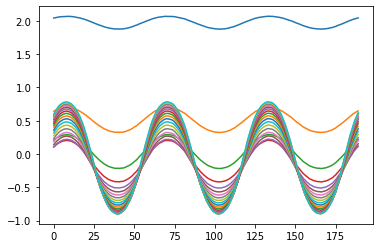

In [216]:
# (X, Y, loss type, # iterations, batch size, learning rate, regulization)
# Loss type('ce': cross-entropy, 'sce': sparse cross-entropy)
lossType = 'mse'
seq_len = 10
epochs = 20000
batchSize = N
learnR = 10e-4
reg = 0
optimizer = 'none'
model.fit(X,Y,seq_len,10000,batchSize,learnR,lossType=lossType,optimizer=optimizer)

In [217]:
M = model.M
W = model.W

In [218]:
yp = model.Yhat

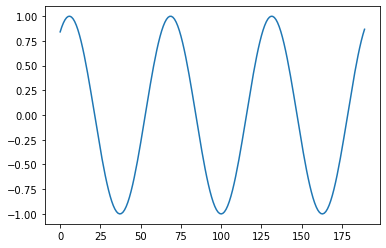

In [219]:
plt.plot(Y)

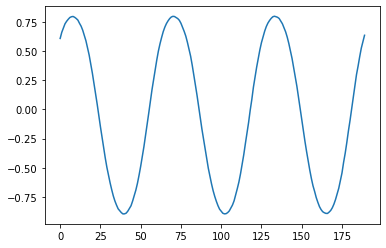

In [220]:
plt.plot(yp)

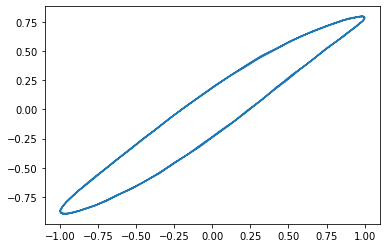

In [221]:
plt.plot(Y,yp)

## Individual methods / testing

In [59]:
def forward(M,W,b,Y):
    N, T, H, D = M[0].shape[0], M[0].shape[1], W[1].shape[1], M[0].shape[2]
    Yp, yp = np.zeros_like(Y), np.zeros_like(Y)
    ht_arr = []
    gt_arr = np.zeros((N,T+1,H,1))
    zt_arr,ht1_arr,ct_arr = np.zeros((N,T+1,H+D,1)),np.zeros((N,T+1,H,1)),np.zeros((N,T+1,H,1))
    it_arr,ft_arr,ot_arr = np.zeros_like(gt_arr),np.zeros_like(gt_arr),np.zeros_like(gt_arr)
    ht_arr.extend([ht1_arr,ct_arr,ft_arr,it_arr,gt_arr,ot_arr,zt_arr])
    
    yt = np.zeros((N,T,1))
    X = M[0]

    for i in range(N):
        ht_prev = M[1][i].T
        ct_prev = np.zeros_like(M[1][i]).T
        for t in range(T):
            z_t = np.row_stack((X[i][t],ht_prev.T)).T
            # W_f = W[0], W_i = W[1], W_g = W[2], W_o = W[3], Why = W[4]
            ft = tanh(z_t.dot(W[0]) + b[0])
            it = tanh(z_t.dot(W[1]) + b[1])
            gt = tanh(z_t.dot(W[2]) + b[2])
            ot = tanh(z_t.dot(W[3]) + b[3])
            ct = ft*ct_prev + it*gt
            ht = ot * tanh(ct)
            yp[i] = (ht.dot(W[4]) + b[4])
            ht_arr[0][i][t] = ht.T
            ht_arr[1][i][t] = ct.T
            ht_arr[2][i][t] = ft.T
            ht_arr[3][i][t] = it.T
            ht_arr[4][i][t] = gt.T
            ht_arr[5][i][t] = ot.T
            ht_arr[6][i][t] = z_t.T
            yt[i][t] = yp[i]
            ct_prev = ct
            ht_prev = ht

        Yp[i] = yp[i]
    return Yp,M,ht_arr,yt

In [60]:
def forward0(M,W,b,Y):
    N, T, H = M[0].shape[0], M[0].shape[1], W[1].shape[0]
    Yp, yp = np.zeros_like(Y), np.zeros_like(Y)
    ht_arr = []
    for i in range(1,len(M)-1):
        H = W[i].shape[1]
        ht_arr.append(np.zeros((N,T+1,H,1)))
    yt = np.zeros((N,T,1))
    X = M[0]

    for i in range(N):
        w = 0
        for j in range(len(M)-2):
            
            hh_prev = M[j].reshape(N,-1,1)
            ht_prev = M[j+1][i]
            # Weight counter 
            for t in range(T):
                ht = tanh((hh_prev[i][t].dot(W[w]) + ht_prev.dot(W[w+1]) + b[j]))
                M[j+1][i] = ht
                ht_prev = ht
                ht_arr[j][i][t] = ht.reshape(-1,1)
            w += 2


        yp[i] = (ht.dot(W[-1]) + b[-1])
        yt[i][t] = yp[i].reshape(-1,1)


        Yp[i] = yp[i]
    return Yp,M,ht_arr,yt

In [61]:
def mse(T,Y):
    tot = np.square(T - Y)
    return tot.sum()

In [62]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [63]:
def tanh(Z):
    return np.tanh(Z)

In [64]:
def actf_dv(Z):
    return Z*(1-Z)

In [65]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1,keepdims=True)

In [66]:
series = np.sin(0.1*np.arange(200))

In [67]:
T = 10
H = 15
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(len(Y),-1)
N = len(X)

In [68]:
# Initialize layers for M
M = []
W = []
b = []
M.append(np.zeros((N,H,D)))
#M.append(np.zeros((N,20)))

# Add input and layer to M
K = 1
M.insert(0,X)
M.append(np.random.randn(N,K))

In [69]:
# Set weights
W = []
b = []
for i in range(len(M)-1):
    if i == (len(M)-2):
        
        W.append(np.random.randn(M[i].shape[1],K) / np.sqrt(M[i].shape[1] + K))
        b.append(np.random.randn(K) / np.sqrt(K))
    else:
        for j in range(4):
            # Whf,Whi,Who,Whc
            W.append(np.random.randn(M[i].shape[2]+M[i+1].shape[1],M[i+1].shape[1]) / np.sqrt((M[i].shape[2]+M[i+1].shape[1]) + M[i+1].shape[1]))
            b.append(np.random.randn(M[i+1].shape[1]) / np.sqrt(M[i+1].shape[1]))

In [ ]:
M1 = M[1].reshape(-1,15,1)

In [66]:
M[1][0].dot(W[2]) + b[1]

array([0.7208181])

In [65]:
(M1[0].T.dot(W[2]) + b[1])

array([[0.7208181]])

In [70]:
Yp,M,ht,yt = forward(M,W,b,Y)

In [116]:
zt = np.row_stack((M[0][0][0],M[1][0]))
htprev = M[1][0].T
z_t = np.row_stack((M[0][0][0],htprev.T)).T

In [117]:
#old
h = tanh(M[0][0][0].dot(W[0][0].reshape(1,15)) + M[1][0].reshape(15).dot(W[1][1:]) + b[0])
y0 = h.dot(W[-1]) + b[-1]
#new
h1 = tanh(zt.T.dot(W[0]) + b[0])
y1 = h1.dot(W[-1]) + b[-1]

In [145]:
ct_prev = np.zeros_like(M[1][0]).T
ft = tanh(z_t.dot(W[0]) + b[0])
it = tanh(z_t.dot(W[1]) + b[1])
gt = tanh(z_t.dot(W[2]) + b[2])
ot = tanh(z_t.dot(W[3]) + b[3])
c_t = ft*ct_prev + it*gt
h_t = ot * tanh(c_t)
y = (h_t.dot(W[4]) + b[4])

In [170]:
h_t, c_t, f_t, i_t, g_t, o_t, z_t  = ht[0], ht[1], ht[2], ht[3], ht[4], ht[5], ht[6]
W_f, W_i, W_g, W_o, W_y = W[0], W[1], W[2], W[3], W[4]

for i in range(N-1,-1,-1):
    dh_next, dc_next = np.zeros_like(h_t[i][-1]), np.zeros_like(c_t[i][-1])
    for t in range(T-1,-1,-1):
        # Get y
        dv_t = (Y[i] - yt[i][t]).reshape(1,-1)
        dW_v = h_t[i][t].dot(dv_t)
        db_v = dv_t.reshape(-1)
        # hidden state
        dh_t = W_y.dot(dv_t)
        dh_t += dh_next
        # output 
        do_t = dh_t * tanh(c_t[i][t])
        da_o = do_t * actf_dv(o_t[i][t])
        dW_o = z_t[i][t].dot(da_o.T)
        db_o = da_o.reshape(-1)
        # cell state
        dc_t = dh_t * o_t[i][t] * actf_dv(c_t[i][t])
        dc_t += dc_next
        # g(cell) gate
        dg_t = dc_t * i_t[i][t]
        da_g = dg_t * actf_dv(g_t[i][t])
        dW_g = z_t[i][t].dot(da_g.T)
        db_g = da_g.reshape(-1)
        # input gate
        di_t = dc_t * g_t[i][t]
        da_i = di_t * actf_dv(i_t[i][t])
        dW_i = z_t[i][t].dot(da_i.T)
        db_i = da_i.reshape(-1)
        # forget gate
        df_t = dc_t * c_t[i][t-1]
        da_f = df_t * actf_dv(f_t[i][t])
        dW_f = z_t[i][t].dot(da_f.T)
        db_f = da_f.reshape(-1)
        # input
        dz_t = W_f.dot(da_f) + W_i.dot(da_i) + W_o.dot(da_o) + W_g.dot(da_g)

        dh_next = dz_t[1:]
        dc_next = dc_t * f_t[i][t]
    derivArray = []
    derivArray.extend([dW_v,dW_o,dW_g,dW_i,dW_f,db_v,db_o,db_g,db_i,db_f])

In [178]:
h_t[0][0].shape

(15, 1)

In [191]:
d[1].shape

(16, 15)

In [22]:
i -= 1
t -= 1
zt = (Y[i] - yt[i][t]).reshape(1,-1)
dwo = (2/N) * ht[i][t].dot(zt)
db1 = zt.sum()
zt = (W[2].dot(zt) + dnext)*actf_dv(ht[i][t])
W[2] += dwo
b[1] += db1
dxh = (2/N) * M[0][i][t].dot(zt.T)
dhh = (2/N) * ht[i][t-1].dot(zt.T)
db0 = zt.sum()
W[1] += dhh
W[0] += dxh
b[0] += db0
dnext = W[1].dot(zt)

In [31]:
for i in range(N-1,-1,-1):
    for t in range(T-1,-1,-1):
        #print(i, t, yt[i][t])
        zt = (Y[i] - yt[i][t]).reshape(1,-1)
        dwo = (2/N) * ht[i][t].dot(zt)
        db1 = zt.sum()
        zt = (W[2].dot(zt) + dnext)*actf_dv(ht[i][t])
        W[2] += dwo
        b[1] += db1
        dxh = (2/N) * M[0][i][t].dot(zt.T)
        dhh = (2/N) * ht[i][t-1].dot(zt.T)
        db0 = zt.sum()
        W[1] += dhh
        W[0] += dxh
        b[0] += db0
        dnext = W[1].dot(zt)

In [163]:
tempa = np.random.randn(15,1)
tempb = np.random.randn(15,1)
tempc = np.random.randn(1,1)

In [159]:
tempa.T.dot(tempb)

array([[-2.0296615]])

In [160]:
tempb.T.dot(tempa)

array([[-2.0296615]])

In [21]:
w2 = np.vstack([b1,W[2]])
w1 = np.vstack([b0,W[1]])
z2 = np.vstack([np.ones((len(Z[2][0]))),Z[2]])
z1 = np.vstack([np.ones((len(Z[1][0]))),Z[1]])

In [30]:
Y1 = np.vstack([np.ones(1),Y])

In [33]:
dw = np.linalg.solve(np.dot(z2.T, z2), np.dot(z2.T, Y1))

In [15]:
dw1 = np.linalg.solve(np.dot(Yp.T, Yp), np.dot(Yp.T, Y))